In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import csv
import functools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import copy

# bibliografie: 
# https://blog.sicara.com/getting-started-genetic-algorithms-python-tutorial-81ffa1dd72f9
# https://www.tutorialspoint.com/genetic_algorithms/index.htm
# https://www.analyticsvidhya.com/blog/2017/07/introduction-to-genetic-algorithm/

# Algoritmi genetici

Calculul maximului functiei $f: [-10, 10] \times [-20, 20] \rightarrow (0, \infty)$,

$$f(x, y) =
100 
\left(
    \left(
       -20 \exp\left( -0.2 \sqrt{0.5 (x^2+y^2)} \right)
       -
       \exp
       \left(
          0.5 \left( \cos(2 \pi x) + \cos(2 \pi y)\right)
       \right)
    \right) + e + 100
\right)
$$

In [2]:
left_interval_1, right_interval_1 = -10, 10
left_interval_2, right_interval_2 = -20, 20 

<IPython.core.display.Javascript object>


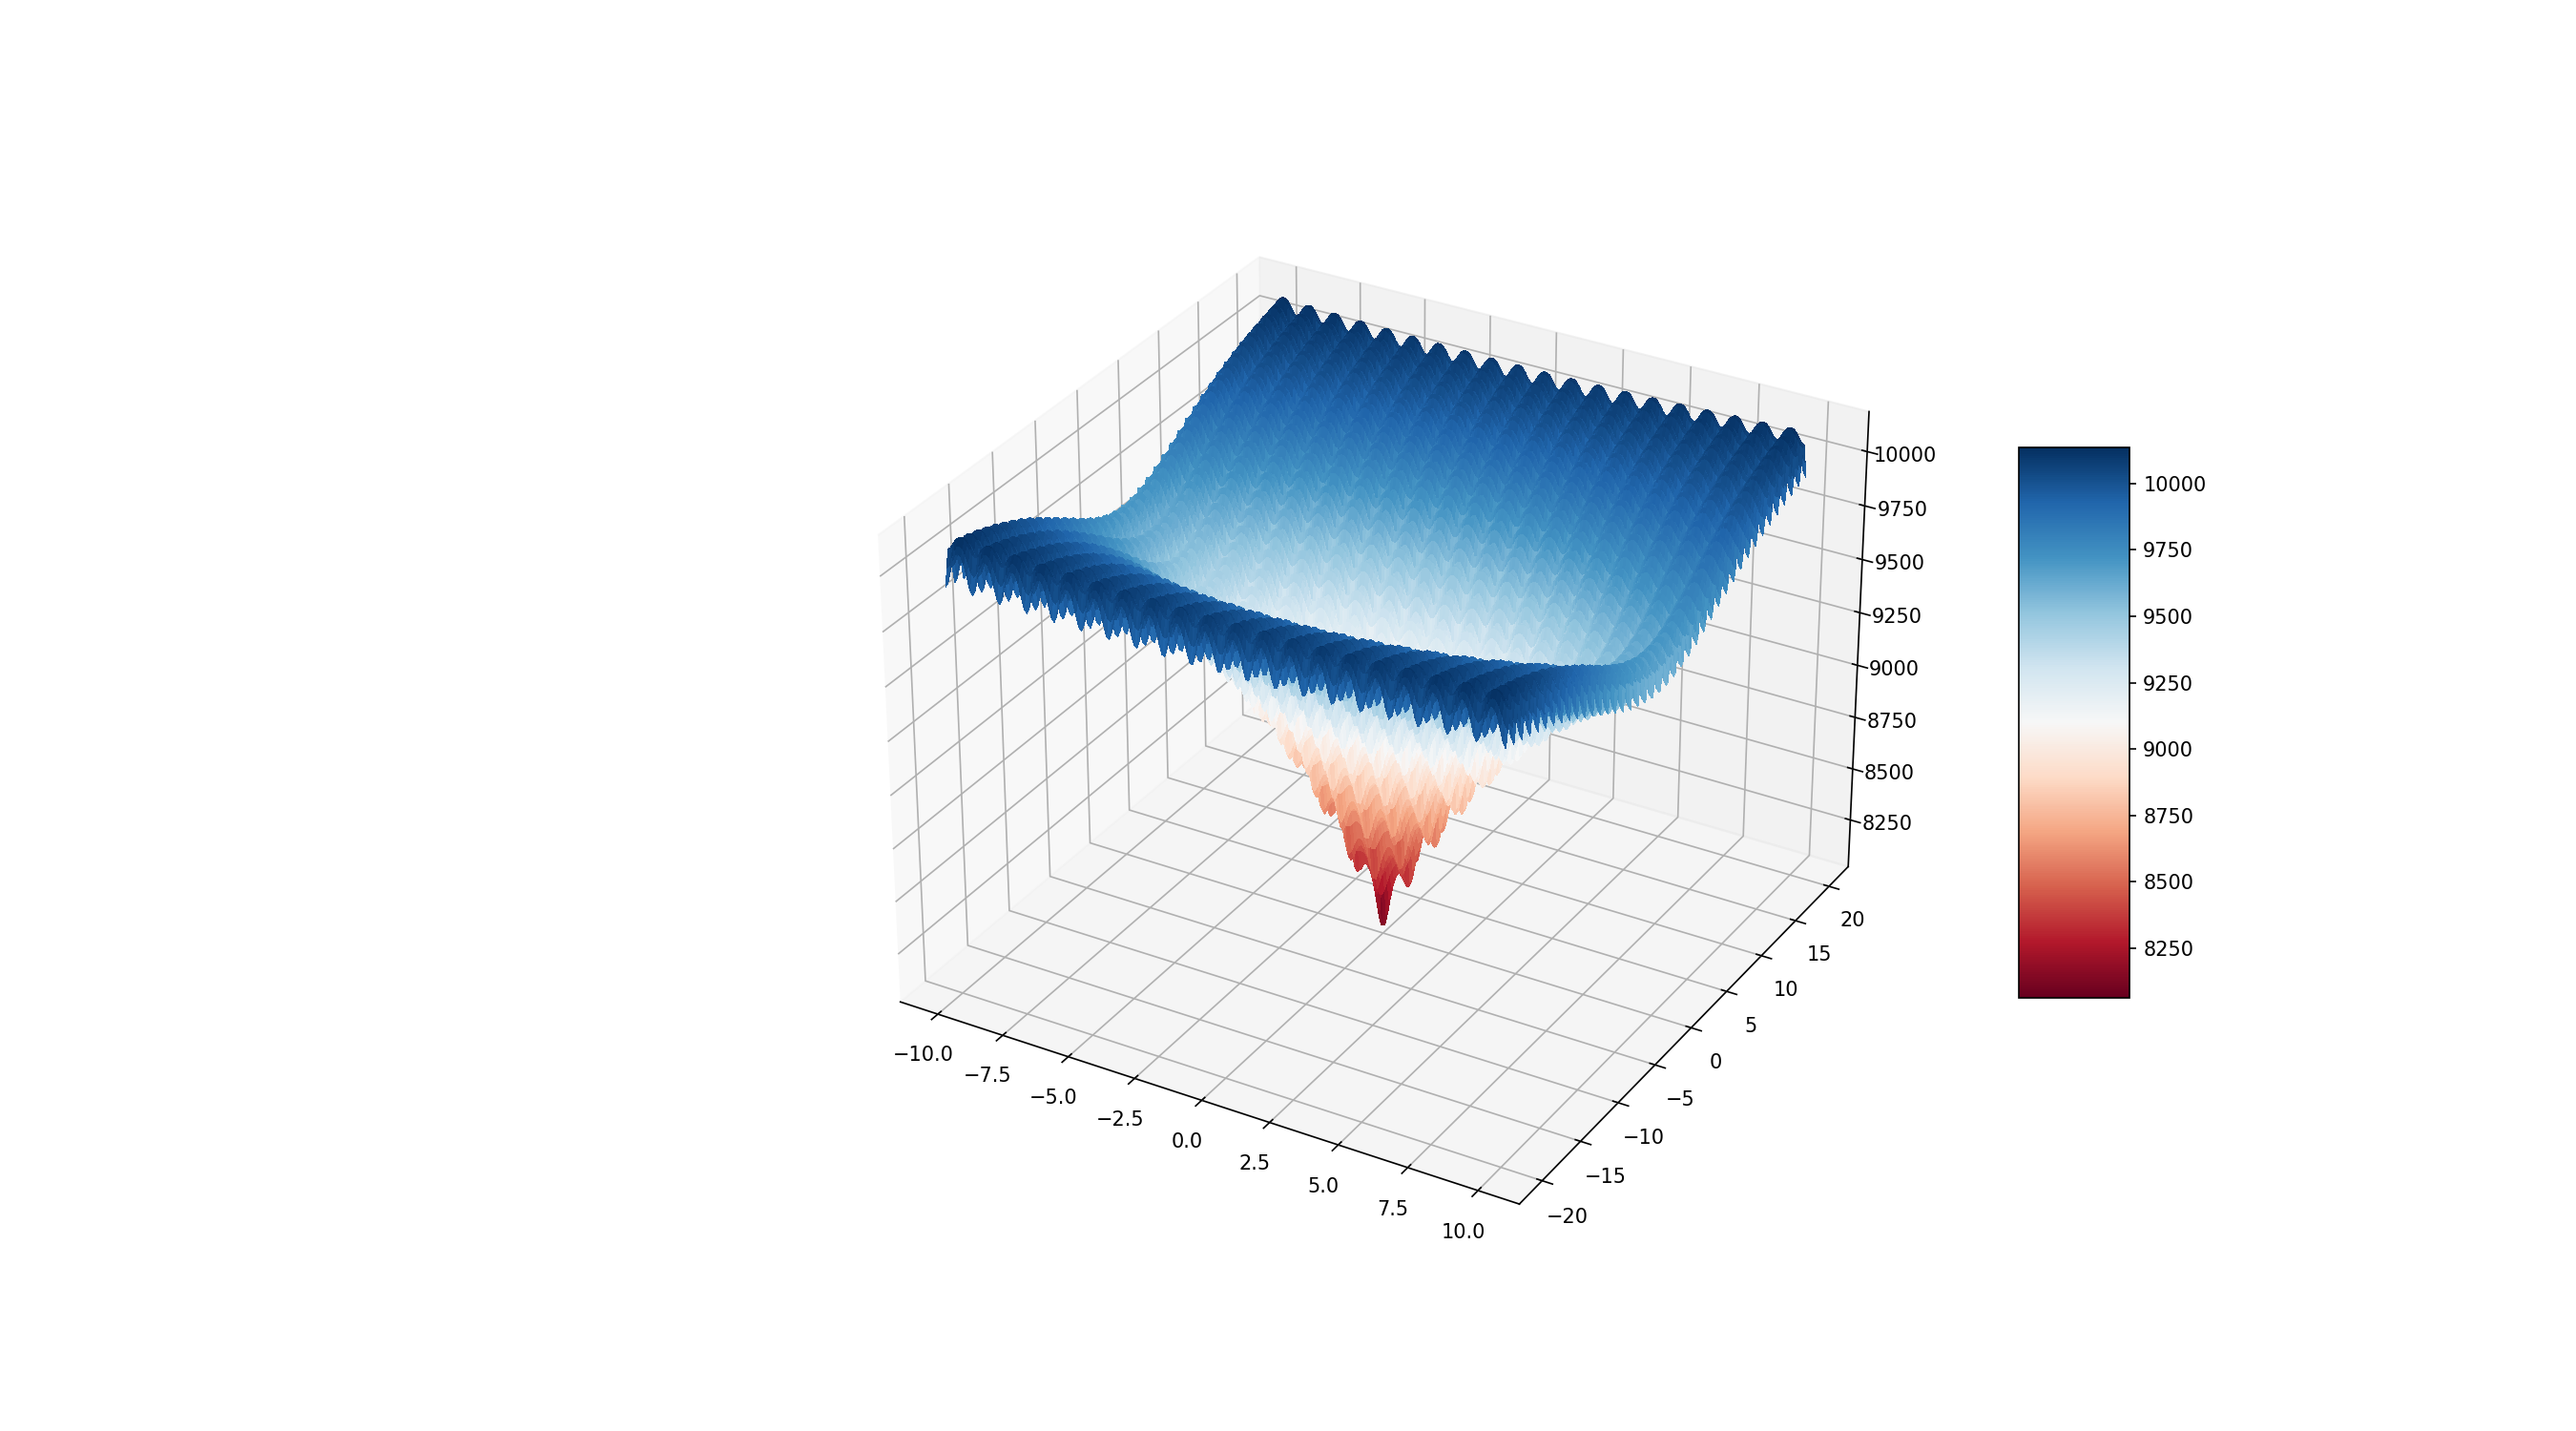

In [3]:
def f(x, y):
    return 100 * (-20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - \
np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 100)


# 200 de puncte pe fiecare directie
sampling = 200

# plt.figure(figsize=(15, 8))

# cream o esantionare de puncte cu numar de puncte dat, pentru fiecare coordonata
x = np.linspace(left_interval_1, right_interval_1, num=sampling)
y = np.linspace(left_interval_2, right_interval_2, num=sampling)

# se creeaza o grila de puncte pe fiecare dimensiune
X, Y = np.meshgrid(x, y)
Z = np.zeros((sampling, sampling))

# se calculeaza valoarea functiei in fiecare punct in acea grila
for i in range(sampling):
    for j in range(sampling):
        Z[i, j] = f(X[i, j], Y[i, j])
        
# crearea unei figuri si setarea dimensiunilor sale
fig = plt.figure()
fig.set_size_inches(18, 10)

# reprezentare 3D
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0, antialiased=False)

# adaugarea legendei si reprezentarea
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Pasi de urmat

1. Se implementeaza functiile de mai jos. Asertiunile trebuie indeplinite
1. La final va rezulta un fisier txt cu structura similara cu cea a fisierului 'exemplu_fisier_iesire.txt' (ignorati continutul numeric, urmariti formatarea)
1. Fisierul de la punctul anterior se va plota in notebookul `plot_GA.ipynb`. Graficul ar trebui sa arate o alura crescatoare a medie populatiei

# Cod

In [4]:
# converteste o lista de k biti in valoare in baza 10

def binary_to_int(bits):
    """
    converteste o lista de k biti in valoare in baza 10
    
    :param bits: lista de biti
    """
    baza10 = 0
    for bit, nr in zip(bits, range(len(bits))):
        baza10 += bit * (2**(len(bits) - nr - 1))
    return baza10
    
assert binary_to_int([0, 0, 0]) == 0
assert binary_to_int([0, 1, 0]) == 2
assert binary_to_int([1, 0, 1]) == 5
assert binary_to_int([1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1]) == 598601

In [5]:
def x_c(v, a, b, k):
    """
    Convert the bit value of v to a value within the interval [a, b]
    :param v: value of current chromozome in base 10
    :param a: left limit of interval
    :param b: right limit of interval
    :param k: numberof bits 
    :return: a value within [a, b]
    """
    return a + v *((b - a) / (2 ** k - 1))

assert(x_c(0, 3, 10, 10) == 3)
assert(x_c((1 << 10) - 1, 3, 10, 10) == 10)
assert(x_c(0, 4, 8, 10) == 4)
assert(x_c((1 << 10) - 1, 4, 8, 10) == 8)

In [6]:
def selection(population):
    """
    Functia de selectie primeste populatia de cromozomi, impreuna cu k, lungimea unui cromozom,
    si creeaza o noua generatie
    
    :param population: lista de tuple de cromozomi; primul cromozom codifica valoare din [3, 10], al doilea din [4, 8]
    :param k: numarul de gene din fiecare cromozom
    
    Un cromozom este o lista de biti.
    
    Va intoarce noua generatie de cromzomi: lista de tuple de 2 cromozomi
    
    Atentie: in populatia selectata, un individ valoros poate sa fie selectat de mai multe ori. 
    Pentru a evita ca mutatiile ulterioare sa afecteze in mod repeatat acelasi individ (aceeasi referinta)
    se va face un deepcopy (copy.deepcopy) al individului depus in populatia selectata
    """
    # population is a list
    assert isinstance(population, list) and len(population) > 1
    # each chromosome is a tuple of two components
    assert all(isinstance(item, tuple) and len(item) == 2 for item in population), 'Should be a list of 2-tuples'
    # each component of a chromosome is a list
    assert all(isinstance(item[0], list) and isinstance(item[1], list) for item in population), 'Any tuple member should be a list'
    # .. and each of these lists have the same length
    assert all(len(item[0]) == len(item[1]) for item in population)
    
    k = len(population[0][0])
    
    # calculeaza lista de valori y cu valorile f(., .) ale indivizilor din populatie
    y = [f(x_c(binary_to_int(pop[0]), 3, 10, k), x_c(binary_to_int(pop[1]), 4, 8, k)) for pop in population]
    
    assert all(f_value > 0 for f_value in y)
    
    # calculeaza s, suma tuturor valorilor din y
    s = sum(y)
    
    # calculeaza probabilitatile de selectie
    p = y/s
    
    pmean = np.mean(p)
    pmin = np.min(p)
#     print(pmin)
    for prob, index in zip(p, range(len(p))):
        if(prob < pmean):
            p[index] -= pmin
        elif(prob > pmean):
            p[index] += pmin
    
#     print(np.max(p))
#     print(pmean)
    p = p/sum(p)
    
    # calculeaza probabilitatea cumulativa de selectie; puteti folosi functia np.cumsum
    q = sum(p)
    print(q)
    
    # creaaza populatia selectata
#     print(np.random.choice(y, size = k, replace = True, p = p))
#     print(k)
    selected = np.random.choice(np.arange(len(population)), size = len(population), replace = True, p = p)
    print(selected)
#     print(np.array(population)[selected])
#     print(np.array(population)[selected].tolist())
    result = []
    for select in np.array(population)[selected].tolist():
        result.append((select[0], select[1]))
    return result

test_population = [
    ([0, 0, 0, 0], [0, 0, 0, 0]),
    ([1, 0, 0, 1], [0, 1, 1, 0]),
    ([0, 1, 1, 0], [1, 0, 0, 0]),
    ([1, 0, 0, 0], [1, 1, 1, 1]),
] * 100
k = len(test_population[0][0])
selected_population = selection(test_population)

assert len(selected_population) == len(test_population)
assert isinstance(selected_population, list) and len(selected_population) > 1
assert all(isinstance(item, tuple) and len(item) == 2 for item in selected_population), 'Should be a list of 2-tuples'
assert all(isinstance(item[0], list) and isinstance(item[1], list) for item in selected_population), 'Any tuple member should be a list'
assert all(len(item[0]) == len(item[1]) == k for item in selected_population)

# the selected chrmosome are among the original chromosomes
assert all(str(item_selected[0]) in set(str(item_original[0]) for item_original in test_population) for item_selected in selected_population)
assert all(str(item_selected[1]) in set(str(item_original[1]) for item_original in test_population) for item_selected in selected_population)

# check if deepcopy was used: the individual id's should be distinct
assert len(selected_population) == len(set(id(individual) for individual in selected_population))
print('bravo')

1.0000000000000004
[327 237 218 186  62  43 219 118 207 249  93 385 186 390 229 181 261 369
  42 190 353 367 113  34 193  82  46 154 119 370  55 347 121  39  42 206
  23 366 305 261 337  37  17 186 229  49 217   3 383  87 198 166  42 159
  21  11 118 197 214 299 330  79 206 306 227 374 158 154 177 250 263 162
 235 142   3 354 301 117 191 363 301 310 282 254  63 117 161 269  51  45
 151 159  71 217 255 163  46 349 174 386 369 315 199 315 102 381 233 279
 234 278 199 274 249 271 221 258 214 289 158 359 231 355 267 191  26 327
 379 113 399 293 366 357   2 213 173 235 310 203 375 339 191 137  61 231
 182 154  95  15 133 394  53  10 333 299 369 246 399 382 203  62  70 214
 357 349 371 339 334 286  18 141 255 326 373  14 154  51   9 178 162  62
  59  97 135 131  53 143 189 186 238 309 191  51 346 339  46 382  75  75
  61  75 347 193 374 189 377 205 254 323 158 191 157  70 195 167 325 239
 285 263 113 125 190  63  50 173  95 393 274 221 326 106 398 302  98 222
  19 350 155 181 169 291 274  11

In [7]:
def crossover_chr(a, b, t):
    """
    Procedura de crossover va genera alti doi cromozomi in care primii t biti din a si b
    vor fi inversati intre cromozomi.
    
    :param a: lista de gene (biti)
    :param b: lista de gene (biti)
    :param t: taietura, 0 < t < k
    :return: un tuplu de 2 liste, continand genele copiilor rezultati
    """
    assert len(a) == len(b)
    k = len(a)
    assert 0 < t < k
#     a_cut, b_cut = a[:], b[:]
#     a_cut[t:], b_cut[t:] = b[t:], a[t:]
    a_cut, b_cut = a[:], b[:]
    a_cut[:t+1], b_cut[:t+1] = b[:t+1], a[:t+1]
    return a_cut, b_cut

a = [1,1,1,1,1,0,0,0,1,1]
b = [0,1,0,0,1,1,1,1,0,0]
a, b = crossover_chr(a, b, 4)
# assert(a == [1,1,1,1,1,1,1,1,0,0])
# assert(b == [0,1,0,0,1,0,0,0,1,1])
assert(a == [0,1,0,0,1,0,0,0,1,1])
assert(b == [1,1,1,1,1,1,1,1,0,0])


In [8]:
def crossover(population, pc = 0.1):
    """
    Selecteaza cativa cromozomi din populatie si face cross-over intre ei, pe perechi
    
    """
    n = len(population)
    k = len(population[0][0])
    t = np.random.randint(1, k - 1)
    return [crossover_chr(pop[0], pop[1], t) if np.random.rand() < pc else pop for pop in population]

crossover_population = crossover(test_population)
# same number of individuals as before
assert len(crossover_population) == len(test_population)
assert isinstance(crossover_population, list) and len(crossover_population) > 1
assert all(isinstance(item, tuple) and len(item) == 2 for item in crossover_population), 'Should be a list of 2-tuples'
assert all(isinstance(item[0], list) and isinstance(item[1], list) for item in crossover_population), 'Any tuple member should be a list'
assert all(len(item[0]) == len(item[1]) for item in crossover_population)


In [9]:
def mutate_chr(a, t):
    """
    Procedura de mutatie va reseta/seta un bit din cromozom
    a este cromozomul reprezentat ca lista de biti
    t este pozitia ce se schimba
    se returneaza un sir de k gene (biti)
    """
    k = len(a)
    assert 0 <= t < k
    b = a
    b[t] = not b[t]
    return b

assert(mutate_chr([1,1,1,1,0,0,0,0,1,1], 6) == [1,1,1,1,0,0,1,0,1,1])
assert(mutate_chr([1,1,1,1,0,0,0,0,1,1], 7) == [1,1,1,1,0,0,0,1,1,1])
assert(mutate_chr([1,1,1,1,0,0,0,0,1,1], 0) == [0,1,1,1,0,0,0,0,1,1])

In [10]:
# mutation
def mutation(population, pm = 0.01):
    """
    Procedura de mutation va produce mutatii in populatie
    pm este probabilitatea mutatiei
    """
    k = len(population[0][0])
    t = np.random.randint(1, k - 1)
    return [(mutate_chr(pop[0], t), mutate_chr(pop[1], t)) if pm > np.random.rand() else pop for pop in population]

mutated_population = crossover(test_population)
# same number of individuals as before
assert len(mutated_population) == len(test_population)
assert isinstance(mutated_population, list) and len(mutated_population) > 1
assert all(isinstance(item, tuple) and len(item) == 2 for item in mutated_population), 'Should be a list of 2-tuples'
assert all(isinstance(item[0], list) and isinstance(item[1], list) for item in mutated_population), 'Any tuple member should be a list'
assert all(len(item[0]) == len(item[1]) for item in mutated_population)
print('bravo')

bravo


In [11]:
def compute_average(population):
    """
    Calculeaza media valorii functiei obiectiv pentru populatia data
    """
    k = len(population[0][0])
    return sum([f(x_c(binary_to_int(pop[0]), 3, 10, k), x_c(binary_to_int(pop[1]), 4, 8, k)) for pop in population])/(len(population))



def maximum(population):
    """
    Calculeaza maximul valorii functiei obiectiv pentru populatia data
    """
    k = len(population[0][0])
    
    return max([f(x_c(binary_to_int(pop[0]), 3, 10, k), x_c(binary_to_int(pop[1]), 4, 8, k)) for pop in population])

In [12]:
def write_population(file, population):
    """
    Scrie populatia in fisierul text file deschis anterior (atentie la conversia \r\n, daca e cazul)
    """
    k = len(population[0][0])
    for a, b in population:
        file.write('cromozom: x=' + str(binary_to_int(a)) + ', y=' + str(binary_to_int(b)) + '\n')
        file.write('valoare: ' + str(f(x_c(binary_to_int(a), 3, 10, k), x_c(binary_to_int(b), 4, 8, k))) + '\n')

In [13]:
# crearea populatiei initiale, 20 de biti per cromozom
k = 20
n = 100

# creeaza populatia, random
population = [
    ((np.random.choice(np.arange(2), k, replace=True)).tolist(),
    (np.random.choice(np.arange(2), k, replace=True)).tolist()) for i in range(n) 
]

print(population)
# deschide fisierul de iesire
file = open("output.txt", "w")

# selection
generations = 50
for i in range(generations):
    # scrie antetul populatiei, "#numar generatie: .."
    #inceput date generatie 0
    file.write('#inceput date generatie ' + str(i) + '\n')
    
    # scrie populatia
    write_population(file, population)
    
    # scrie #sfarsit date generatie 
    file.write('#sfarsit date generatie ' + str(i) + '\n')
    
    # tipareste pe ecran media populatiei si maximul
    # pe parcursul generatiilor, media populatiei ar trebui sa fie monoton crescatoare
    print('Generation: ' + str(i))
    print('Media: ' + str(compute_average(population)))
    print('Maximul: ' + str(maximum(population)) + '\n')
    
    # apeleaza, in ordine, selection, crossover si mutation
    population = selection(population)
    population = crossover(population)
    population = mutation(population)
    
# scrie media si maximul ultimei iteratii
print('Ultima iteratie:')
print('Media: ' + str(compute_average(population)))
print('Maximul: ' + str(maximum(population)))

# inchide fisierul
file.close()

[([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1], [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]), ([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0], [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]), ([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0], [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]), ([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0], [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]), ([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]), ([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]), ([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1], [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]), ([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1], [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,

[91 17 43 69 80 72 25 11 74 28 25 95 46 45 43 84 83 39 80 74 45 83 62 97
 83 27 93 40 81 86 50 32 43 13 49 17 35  0 82 76 58 74 39  2 52 81 92 55
 83  4 28 28 46 50 79 44 20 63 84  2 43 64 28 35 11 46 27 27 62 44 77 56
 20 40 77 93  2 72 85 92 99 39 94 56 81 83 99 44 99 76 93 13 22 74 69 39
 17 99 46 11]
Generation: 2
Media: 9749.906952538038
Maximul: 9873.37982086981

1.0000000000000004
[42 34 61 59 78 21 67 17 24 68 64 46 68 46 38 43 90 64 58 66 21 44 28 34
 67 67 37 59 79 79 64 83 64 67 59 15 67 70 45 49 85  7 64 79 75  7 99 78
 45 83 71 75 16 79  7 71 45 26 78 45 90 45 90 17 90 46 84 81 68 37 43 34
 64 15 66 45 26 43 99 85 34 45  7 49 25 58 78 44 17 16 28 48 68 42 85 11
 85 15 78 37]
Generation: 3
Media: 9793.702662341228
Maximul: 9873.37982086981

1.0000000000000002
[34  2 69 49 15 34 94  8 92 40 34  5 50 12  8 68 31 68 70 79 69 91 52 34
 18 40 85  2  2 97 27  2 40 70 97 97 52  2 12 27 27 91 18 95 27 85 52 96
 92 73 52 69 15 73  3 35 77 69 55 27 85  8 94 77 18  8 27 79 97  2 68 24

Generation: 24
Media: 9861.823301208242
Maximul: 9873.37982086981

1.0000000000000044
[26 11 31 18 44 34 87 12 96  4 34 11 29 75 87 91 43 89 44 50 83  0 57  5
 75 90 57 83 22 21 71 43 28 57 34 30 48 69 37  3 49 37 31 44 12 62 73 99
 20 59  4 11 92 13  9 93 54 96  2 11 47 73 88 16 30 91 35 58  9 70 11 91
 54  5 61 61  0 95  5 87 75 22 54 71 91 10 34 18 19 37 39 36 22 94 77 81
 75  9 67 21]
Generation: 25
Media: 9856.654029629715
Maximul: 9873.380745928658

1.0000000000000007
[55 62 64 34 70 74 25 92  4  5 24 72 39 71 64 90 94 79 70 36 90  3 39 68
 49 72 96 65 85  4 90 21 12 15  3 88  4 41 21 69 30 65 53 29 26 16 58 26
 24 25 72  2 85 37 63 92 10 69 67 84 19 50 15 92  9 49 64 30 81  7 53  0
 60 82 40 30 95 24  0 73 95 91 34  3 70 38 79 35 51  7 91 18 64 26 12 98
 42 71 93 92]
Generation: 26
Media: 9860.514035875305
Maximul: 9873.380745928658

0.9999999999999993
[69 12  8 69 36 58  3 84 25 77 42 31 64 11 93 45 72 55 92 79 98 44 23 98
 68 19 10 12 72 99 48 23 71 27 56 51 94 42 86 57 74 79 

Generation: 45
Media: 9853.408721392167
Maximul: 9873.668502254082

0.9999999999999983
[76 14  6 43 20 45 50 16 36 30 55 37 73 76 92 29  9 87 68  6 73 83 68 91
 88 91 49 88 59 25 55 56  0 20  5 78 59 31  5 28 41 58 56 43 47 54 67 44
 13 33  8 82 43 80 71 68 26 31 85 68 51 97 41 37 14 49 73 52  9 94 49 58
 45 63 47 42 43  9 13 53 53 34 49  8 29  9 51 81 14  3 57 49 82 85 19  8
 42 14 35 72]
Generation: 46
Media: 9864.671682601465
Maximul: 9873.668502254082

0.9999999999999968
[47  0 80 92 53 73 10 97 36 36  8 64 86  9 40 35 94 51 19 88 86 36 43  6
 55 84  0 63 92 45 85 26 74 14  7 48 45 30 30 35  0 74 83 74 18 95 49 77
 85  0 29 24 86  7 64 32 99 88  8 60 16 58 39 40 32  0 33 70 61 18 21  9
 95 65  7 75 14 36 68 34 28 44 92 81 21 89 76 28 86 87 60 21 52 96 14 56
  9 77 19 61]
Generation: 47
Media: 9860.83188123068
Maximul: 9873.668502254082

0.9999999999999978
[49 79 99 36 79 34 52 46 63 98 29 89 63  2 29 62 27  9 86  7 22 56 29 95
 46 58 30 12 63 85 87 77 66  8 56  8 99 31  5 45 64 97 